# Condensation Tutorial: Moving Bin

*Work in progress, probably split into multiple notebooks, need to find a model system to test this on*

Condensation, is the first process where this framework we have been building up is applied. Here we need to account for the gas phase, and the particle phase. Then ensure that the partial pressures of species at the surface of the particle are equal to the partial pressure in the gas.

### Core Concepts:

- **Runnable**: An abstract base class defining the interface for aerosol transformation processes.
  - Here and aerosol object is passed to the process, and the process is expected to modify the aerosol object in place, returning the modified object.
- **MassCondensation**: A concrete class implementing the RunnableProcess interface for the condensation process. Is an implementation of a `Runnable` process that adds mass to the aerosol object based on the partial pressures of the gas phase and the particle phase. Then removes the mass from the gas phase.


In [1]:
from copy import copy
import numpy as np
import matplotlib.pyplot as plt

# particula imports
from particula.next.particles.representation_builders import (
    LimitedRadiusParticleBuilder,
)
from particula.next.gas.atmosphere_builder import AtmosphereBuilder
from particula.next.gas.vapor_pressure_factories import VaporPressureFactory
from particula.next.gas.species_builder import GasSpeciesBuilder
from particula.next.aerosol import Aerosol
from particula.next.dynamics.particle_process import MassCondensation
from particula.next.dynamics.condensation import CondensationIsothermal

## Aerosol Object

First we will repeat the aerosol object that we have been using in the previous notebooks. This object will be passed to the `Runnable` processes `MassCondensation`, and modified in place.

In [2]:
# Glycerol gas
molar_mass_glycerol = 92.09382e-3  # kg/mol
parameters_clausius = {
    "latent_heat": 71.5 * molar_mass_glycerol,
    "latent_heat_units": "kJ/kg",
    "temperature_initial": 125.5,
    "temperature_initial_units": "degC",
    "pressure_initial": 1,
    "pressure_initial_units": "mmHg",
}
vapor_pressure_strategy = VaporPressureFactory().get_strategy(
    "clausius_clapeyron", parameters_clausius
)

sat_concentration = vapor_pressure_strategy.saturation_concentration(
    molar_mass_glycerol, 298.15
)
print(f"Saturation concentration: {sat_concentration:.2e} kg/m^3")

sat_factor = 0.001  # 50% of saturation concentration
glycerol_gas = (
    GasSpeciesBuilder()
    .set_molar_mass(molar_mass_glycerol, "kg/mol")
    .set_vapor_pressure_strategy(vapor_pressure_strategy)
    .set_concentration(sat_concentration * sat_factor, "kg/m^3")
    .set_name("Glycerol")
    .set_condensable(True)
    .build()
)

atmosphere = (
    AtmosphereBuilder()
    .add_species(glycerol_gas)
    .set_temperature(25, temperature_units="degC")
    .set_pressure(1, pressure_units="atm")
    .build()
)

# Glycerol particle distribution
bins = np.logspace(-8, -5, 500)
lognormal_rep = (
    LimitedRadiusParticleBuilder()
    .set_mode(np.array([100]), "nm")
    .set_geometric_standard_deviation(np.array([1.3]))
    .set_number_concentration(np.array([1e4]), "1/cm^3")
    .set_density(1.26, "g/cm^3")
    .set_distribution_type("pmf")
    .set_radius_bins(bins, "m")
    .build()
)

print(f"Particle shape {np.shape(lognormal_rep.distribution)}")
print(f"Gas_species {np.shape(atmosphere.species)}")

aerosol = Aerosol(atmosphere=atmosphere, particles=lognormal_rep)

count = 0
for gas_species in aerosol.iterate_particle():
    count += 1
    print(f"Particle {count}")

print(aerosol.atmosphere)
print(aerosol.particles[0].get_total_mass())

Saturation concentration: 2.54e-03 kg/m^3
Particle shape (500,)
Gas_species (1,)
Particle 1
Gas mixture at 298.15 K and 101325.0 Pa consisting of ['Glycerol']
7.194243641195577e-08


## Condensation Process (Isothermal)

In code this process is implemented as a `Runnable` process. This means that the process is expected to modify the aerosol object in place, returning the modified aerosol object. This is defined in `Particle_processes.py` as the `MassCondensation` class.

The `MassCondensation` class takes a `CondensationStrategy` object as an input. This object defines and evaluates the $dm_{i}/dt$ equation for the condensation process. More strategies can be added into the `condensation.py` file.

For now, let's just run it for a few time steps and see what happens.

Note: We have a moving bin particle representation, so we would expect all the bins to move.

Glycerol
early return
Pressure delta shape: (500,)
Mass rate shape: (500,)
Initial rate shape: (500,)
early return
Pressure delta shape: (500,)
(500,)
(500,)
(500,)


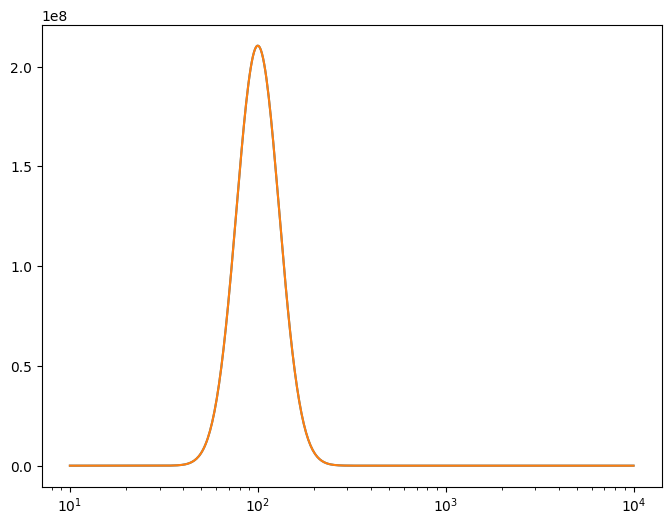

In [4]:
# define the condensation process
condensation_isothermal = CondensationIsothermal(
    molar_mass=molar_mass_glycerol,
    diffusion_coefficient=2.0*1e-9,
    accommodation_coefficient=0.00005,  #makes things go slower/faster
)
condensation_process = MassCondensation(condensation_strategy=condensation_isothermal)

# define the time array in seconds
time_step = 0.01
time_array = np.arange(0, 0.1, time_step)
total_mass = np.zeros_like(time_array)

# output arrays
aerosol_sim = []

rate = condensation_process.rate(aerosol)

# print(f"Inital rate: {rate[:5]}...")
print(f"Initial rate shape: {rate.shape}")

fig, ax = plt.subplots(figsize=(8, 6))
ax.semilogx(aerosol.particles[0].get_radius()*1e9, aerosol.particles[0].concentration, label="Initial")
# singe step
aerosol = condensation_process.execute(aerosol, time_step)
ax.semilogx(aerosol.particles[0].get_radius()*1e9, aerosol.particles[0].concentration, label="After 1 step")
# # second step
# aerosol = condensation_process.execute(aerosol, time_step)
# ax.semilogx(aerosol.particles[0].get_radius()*1e9, aerosol.particles[0].concentration, label="After 2 steps")
# # 5th step
# aerosol = condensation_process.execute(aerosol, time_step)
# aerosol = condensation_process.execute(aerosol, time_step)
# aerosol = condensation_process.execute(aerosol, time_step)
# ax.semilogx(aerosol.particles[0].get_radius()*1e9, aerosol.particles[0].concentration, label="After 5 steps")
# plt.legend()
# ax.set_xlabel("Radius (nm)")
# ax.set_ylabel("Concentration (1/m^3)")
# plt.show()


## Summary

We built out the condensation process, and the equations that define the process. We also defined the inputs and outputs of the process. Next we will build out coagulation and nucleation processes, to complete the aerosol dynamics framework.